# Implementing Markov Chain Monte Carlo approach's Gibbs Sampling on generated data

In [1]:
# Import necessary libraries
import random
import time
import numpy as np
import math
import sys
from google.colab import drive
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [2]:
# Function to read sequences from input file given
# Input: sequence_count
# Output: Returns dna sequences

def read_sequences_from_input_file(sequence_count):

  # Reading sequences from the file
  dna_input_path = base_path + "differential_privacy_enforced_sequences_" + str(sequence_count) + ".txt"
  file_ptr = open(dna_input_path, 'r')
  seq_title_line, dna_sequences = True, []

  for each_seq in file_ptr:
    if seq_title_line:
      seq_title_line = False
    elif seq_title_line == False:
      dna_sequences.append(each_seq.strip('\n'))
      seq_title_line = True
  file_ptr.close()
  
  return dna_sequences


In [3]:
# Function to store results obtained to respective files
# Input: sequence_count, information_vector, profile_matrix
# Output: Does not return anything. Instead, it saves results to respective files

def store_results_to_respective_files(sequence_count, information_vector, profile_matrix):

  # Writing results to respective files
  # Result: predicted motif sites in dna sequences
  predicted_sites = information_vector[1][-1]
  output_sites_file = base_path + "predicted_sites_" + str(sequence_count) + ".txt"
  file_ptr = open(output_sites_file, 'w')
  for idx in range(0, len(predicted_sites)):
    file_ptr.write(str(predicted_sites[idx]) + '\n')
  file_ptr.close()

  # Result: Obtained motif
  output_motif_file = base_path + "predicted_motif_" + str(sequence_count) + ".txt"
  file_ptr = open(output_motif_file, 'w')
  file_ptr.write(motif_result + '\n')
  for row in range(0, len(profile_matrix)):
    for col in range(0, len(profile_matrix[row])):
      file_ptr.write(str(int(profile_matrix[row][col])) + '\t')
    file_ptr.write('\n')
  file_ptr.close()


In [4]:
# Function to compute the Position Weight Matrix (PWM) for N-1 sequences
# Input: dna_seqeunces, no_of_sequences, motif_length, sequence_length, motif_sites 
# Output: Returns pwm and ignored sequence

def compute_position_weight_matrix(dna_seqs, no_of_seqs, motif_len, seq_len, motif_sites):

  # To ignore a sequence, we generate a random number
  random.seed(time.time())
  ignored_seq = random.randrange(0, no_of_seqs)

  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  pwm = np.zeros((4, motif_len))

  # Indexing the N-1 sequences
  idx = 0

  for seq_idx in range(0, no_of_seqs):

    # We ignore the previously selected random sequence
    if seq_idx == ignored_seq:
        continue

    else:
      for m_len in range(0, motif_len):
        value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
        if value == nucleotides[0]:
          pwm[0][m_len] += 1
        elif value == nucleotides[1]:
          pwm[1][m_len] += 1
        elif value == nucleotides[2]:
          pwm[2][m_len] += 1
        elif value == nucleotides[3]:
          pwm[3][m_len] += 1
    idx += 1

  return pwm/(no_of_seqs - 1), ignored_seq


In [5]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: dna_seqeunces, ignored_seq, pwm, motif_length, sequence_length
# Output: Returns the predicted site

def predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_len, sequence_len):

  # Obtaining all possible prediction candidates of given motif length
  prediction_candidates = []
  for i in range(0, sequence_len - motif_len + 1):
    prediction_candidates.append((dna_sequences[ignored_seq])[i:i + motif_len])

  # Generating probabilities for all candidates to find the best possible prediction
  candidate_probabilities = []
  for pred_idx in range(0, len(prediction_candidates)):
    frequency, weighted_frequency = 1, 1

    for m_len in range(0, motif_len):
      value = prediction_candidates[pred_idx][m_len]
      if value == nucleotides[0]:
        frequency *= freq[0]
        weighted_frequency *= pwm[0][m_len]
      elif value == nucleotides[1]:
        frequency *= freq[1]
        weighted_frequency *= pwm[1][m_len]
      elif value == nucleotides[2]:
        frequency *= freq[2]
        weighted_frequency *= pwm[2][m_len]
      elif value == nucleotides[3]:
        frequency *= freq[3]
        weighted_frequency *= pwm[3][m_len]
    candidate_probabilities.append(weighted_frequency / frequency)

  # Normalizing the probabilities to obtain the predicted site
  normalized_probabilities = list(candidate_probabilities / sum(candidate_probabilities))
  predicted_site = normalized_probabilities.index(max(normalized_probabilities))
  return predicted_site


In [6]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: motif_sites, dna_seqeunces, motif_length, no_of_seqs, pwm
# Output: Returns information content and updated pwm

def compute_information_content(motif_sites, dna_seqs, motif_len, no_of_seqs, precomputed_pwm):
  
  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  updated_pwm = np.zeros((4, motif_len))
  
  # Indexing the N-1 sequences
  idx = 0

  # Computing updated PWM
  for seq_idx in range(0, no_of_seqs):
    for m_len in range(0, motif_len):
      value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
      if value == nucleotides[0]:
        updated_pwm[0][m_len] += 1
      elif value == nucleotides[1]:
        updated_pwm[1][m_len] += 1
      elif value == nucleotides[2]:
        updated_pwm[2][m_len] += 1
      elif value == nucleotides[3]:
        updated_pwm[3][m_len] += 1
    idx += 1
  updated_pwm = updated_pwm / no_of_seqs

  # Finding the information content based on the updated PWM
  info_content = 0
  for m_len in range(0, motif_len):
    for nuc_no in range(0, 4):
      if nuc_no == 0:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[0]
      elif nuc_no == 1:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[1]
      elif nuc_no == 2:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[2]
      elif nuc_no == 3:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[3]
      if normalized_pwm == 0:
        continue
      info_content += updated_pwm[nuc_no][m_len] * math.log(normalized_pwm, 2)

  return info_content, updated_pwm


In [7]:
# Function to find max PWM and max info content
# Input: iterations, dna_sequences, motif_length, sequence_length, motif_sites
# Output: Returns information content, pwm and information vector

def compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, acceptable_info_content):

  # Declaring required variables
  added_prediction, max_info_content, iter_count = False, 0, 0
  information_vector = [['IC'], ['sites']]
  no_of_seqs = len(dna_sequences)

  # Runs multiple iterations to obtain right values
  for iteration in range(0, iterations):

    # Finding the Position Weight Matrix (PWM) for N-1 sequences
    pwm, ignored_seq = compute_position_weight_matrix(dna_sequences, no_of_seqs, motif_length, sequence_length, motif_sites)

    # Predicting the site in the ignored sequence using the PWM
    predicted_site_in_ignored_seq = predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_length, sequence_length)

    # Adding the predicted site to the list if it is not yet added
    if added_prediction == False:
      motif_sites.insert(ignored_seq, predicted_site_in_ignored_seq)
      added_prediction = True
    else:
      motif_sites[ignored_seq] = predicted_site_in_ignored_seq
    motif_sites_temp = motif_sites[:]

    # Computing the information content of the prediction in the current iteration
    information_vector[1].append(motif_sites_temp)
    info_content, pwm = compute_information_content(motif_sites, dna_sequences, motif_length, no_of_seqs, pwm)
    information_vector[0].append(info_content)

    # Updating max. information content value
    if info_content > max_info_content:
      max_info_content = info_content
      max_pwm = pwm

    if info_content > (acceptable_info_content * motif_length):
      break

  # Updating info_content & pwm with the max. values respectively
  info_content = max_info_content
  pwm = max_pwm
  
  return info_content, max_pwm, information_vector


In [8]:
# Function to find motif from pwm using the sequences and motif length
# Input: pwm, no_of_seqs, motif_length
# Output: Returns motif result and profile matrix

def find_motif_from_pwm(pwm, no_of_seqs, motif_length):

  # Obtaining the motif from given dna sequences using Position Weight Matrix
  profile_matrix = np.transpose(pwm) * no_of_seqs
  motif_temp = []
  for m_len in range(0, motif_length):
    values_at_mlen = list(profile_matrix[m_len])
    max_value = max(values_at_mlen)

    # As two nucleotides may have equal probability of occurrence, we check if the max_value appears more than once
    max_value_indices = []
    for idx in range(0, len(values_at_mlen)):
      if values_at_mlen[idx] == max_value:
        max_value_indices.append(idx)
    
    if len(max_value_indices) > 1:
      motif_index = random.choice(max_value_indices)
    else:
      motif_index = values_at_mlen.index(max(values_at_mlen))
    
    motif_temp.append(nucleotides[motif_index])
  motif_result = ''.join(motif_temp)

  return motif_result, profile_matrix


In [9]:
# Function to find the percentage of sequences that have a minimum match of 50% of motif
# Input: all_dna_sequences, motif_results
# Output: Returns motif counts

def find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results):
  
  # Finding the percentage match of motif in each input dna sequence
  motif_counts = {}
  print("Original motif counts:")

  for sequences in all_dna_sequences:
    motif_cnt = [0, 0, 0, 0, 0]
    data_size = len(sequences)

    for motif_idx in range(0, 5):
      motif = motif_results[motif_idx]
      for each_sequence in sequences:
        # seq_lenth = 300 and motif_length = 10
        # If atleast 5 characters are matched, it is good
        # So, percentage match should be 5/300 ~ 0.015
        if SequenceMatcher(None, motif, each_sequence).ratio() >= 0.01:
          motif_cnt[motif_idx] += 1
        
    print(motif_cnt, "for ", data_size, " dna sequences")
    motif_counts[data_size] = motif_cnt
    
  return motif_counts


In [10]:
# Function to find the normalized motif counts from actual counts
# Input: motif_counts
# Output: Returns normalized motif counts

def compute_normalized_motif_counts(motif_counts):

  # To plot the motif counts along the same scale, we normalize the counts
  normalized_motif_counts = {}
  print("\n\nNormalized motif counts:")

  for key in motif_counts:
    normalized_list = []
    for each_val in motif_counts[key]:
      normalized_list.append(each_val / key)
    normalized_motif_counts[key] = normalized_list
    print(normalized_motif_counts[key])

  return normalized_motif_counts


In [18]:
# Function to plot the motif match observations made
# Input: motif_results, normalized_motif_counts
# Output: Displays different bar graphs for various input sizes

def plot_motif_match_observations(motif_results, normalized_motif_counts):
  
  # Plotting normalized motif counts across the dna sequences considered
  idx = 0

  for key in normalized_motif_counts:
    x_axis = motif_results
    y_axis = normalized_motif_counts[key]
    
    bar_chart = plt.figure(figsize = (8, 5))
    plt.bar(x_axis, y_axis, color = 'purple')
    plt.xticks(rotation=30, ha='right')
    plt.yticks(np.arange(0, 0.10, 0.02))
    plt.xlabel("Motifs found")
    plt.ylabel("Dna sequences which matched atleast 50% of motif_length")
    plt.title("Plot for " + str(key) + " sequences")
    
    idx += 1
    plt.show()


In [12]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/DNA-Dataset/Data/"


Mounted at /content/drive


In [13]:
# Define required variables
nucleotides = ['A','G','T','C']
freq = [0.25, 0.25, 0.25, 0.25]
sequence_length = 300   # Fixed: As the DNA contains 150 base pairs in general
motif_lengths = [10, 15, 20, 25, 30, 35, 40]   # Motifs are generally 5-20 pairs long
sequence_counts = [1000, 5000, 10000, 50000, 100000]
info_content = 1.75


In [14]:
# For various information content values, we analyze the results
motif_results_per_motif_length = {}

for motif_length in motif_lengths:
  print("\n\nMOTIF LENGTH: ", motif_length, "\n")

  # Executing Gibbs algorithm and store motif results obtained
  motif_results, profile_matrices, all_dna_sequences = [], [], []
  idx = 0

  for sequence_count in sequence_counts:

    # Read DNA data from input files
    dna_sequences = read_sequences_from_input_file(sequence_count)
    all_dna_sequences.append(dna_sequences)
    
    no_of_seqs = len(dna_sequences)
    print("No. of DNA sequences: ", no_of_seqs)

    # As in Gibbs sampling, we select random starting points and 
    # generate motif site for all the remaining sequences
    motif_sites = []
    for i in range(0, no_of_seqs-1):
      random_start_site = random.randrange(0, sequence_length - motif_length)
      motif_sites.append(random_start_site)

    # Implementing Gibbs algorithm with several iterations
    # Fixed to nalayze ic effect
    iterations = 100
    info_content, pwm, information_vector = compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, info_content)
    motif_result, profile_matrix = find_motif_from_pwm(pwm, no_of_seqs, motif_length)
    motif_results.append(motif_result)
    profile_matrices.append(profile_matrix)
    store_results_to_respective_files(sequence_count, information_vector, profile_matrix)

    # Analyzing the results obtained
    print("Motif discovered: ", motif_results[idx], "\n")
    print("-----------------------\n")
    idx += 1

  # Finding motif counts for various motif length values
  motif_counts = find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results)
  normalized_motif_counts = compute_normalized_motif_counts(motif_counts)
  motif_results_per_motif_length[motif_length] = [normalized_motif_counts, motif_results]
  print("\n****************************************")




MOTIF LENGTH:  10 

No. of DNA sequences:  1000
Motif discovered:  TTTACAGCTG 

-----------------------

No. of DNA sequences:  5000
Motif discovered:  TAAACCTAAT 

-----------------------

No. of DNA sequences:  10000
Motif discovered:  AATTCACTTA 

-----------------------

No. of DNA sequences:  50000
Motif discovered:  AGGATTGCAT 

-----------------------

No. of DNA sequences:  100000
Motif discovered:  CATAAACTGT 

-----------------------

Original motif counts:
[64, 56, 53, 60, 59] for  1000  dna sequences
[356, 290, 305, 294, 296] for  5000  dna sequences
[621, 617, 614, 648, 593] for  10000  dna sequences
[3132, 3176, 3076, 3107, 3132] for  50000  dna sequences
[6246, 6288, 6196, 6301, 6152] for  100000  dna sequences


Normalized motif counts:
[0.064, 0.056, 0.053, 0.06, 0.059]
[0.0712, 0.058, 0.061, 0.0588, 0.0592]
[0.0621, 0.0617, 0.0614, 0.0648, 0.0593]
[0.06264, 0.06352, 0.06152, 0.06214, 0.06264]
[0.06246, 0.06288, 0.06196, 0.06301, 0.06152]

***************************

In [16]:
print(motif_results_per_motif_length[20])

[{1000: [0.071, 0.064, 0.053, 0.059, 0.072], 5000: [0.058, 0.0712, 0.061, 0.061, 0.0624], 10000: [0.0619, 0.0621, 0.0614, 0.061, 0.0602], 50000: [0.0624, 0.06264, 0.06152, 0.0635, 0.06298], 100000: [0.06319, 0.06246, 0.06196, 0.06215, 0.06179]}, ['GGCAATGGGGCCCTTACGTC', 'TTAAATTGATACGCACTAGC', 'AAATGTTAAGAAAAAATTAC', 'ACTGCGAGAAGCCCTCAATT', 'GTATGACACGGTGCAACGCC']]


FOR MOTIF LENGTH:  10


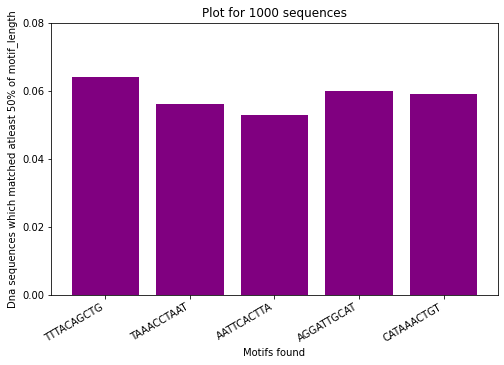

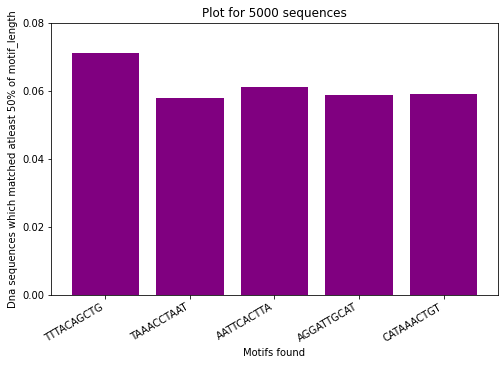

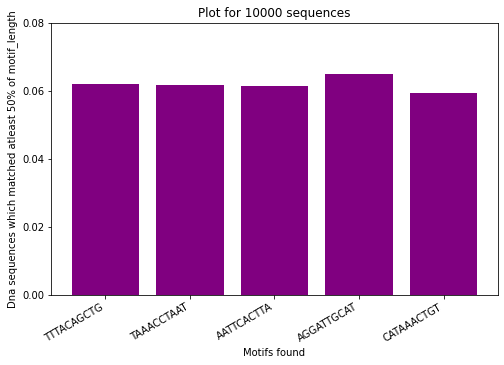

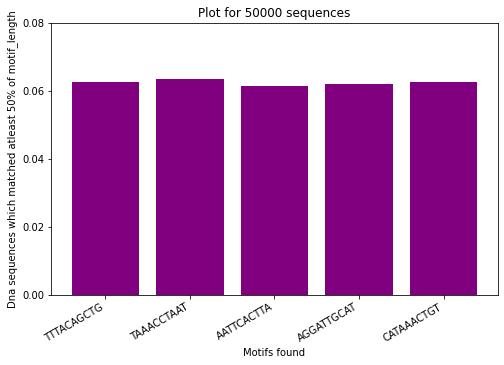

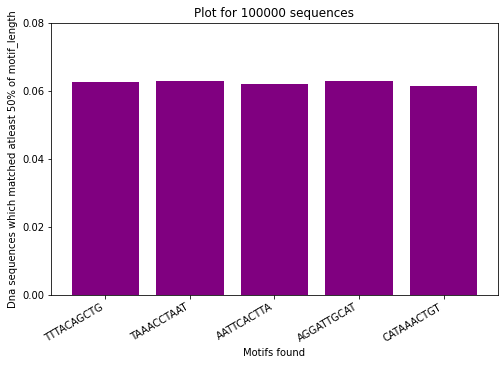

FOR MOTIF LENGTH:  15


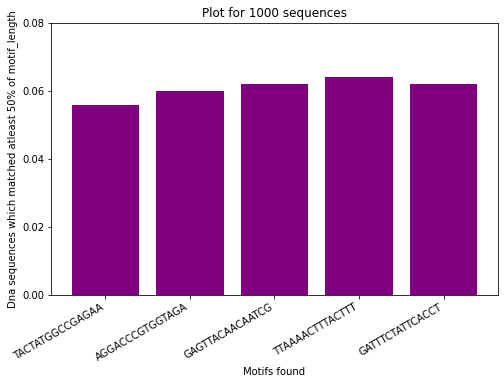

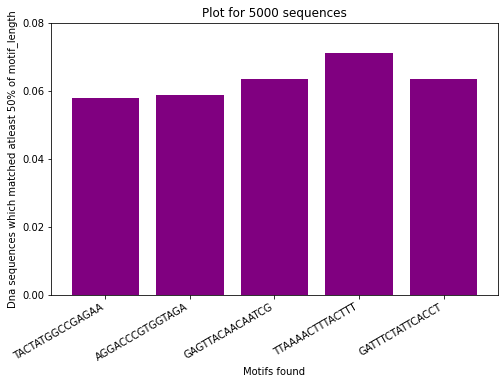

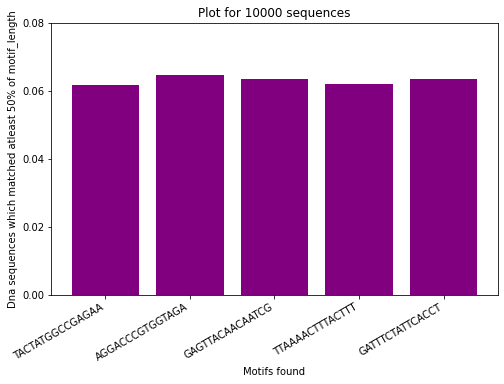

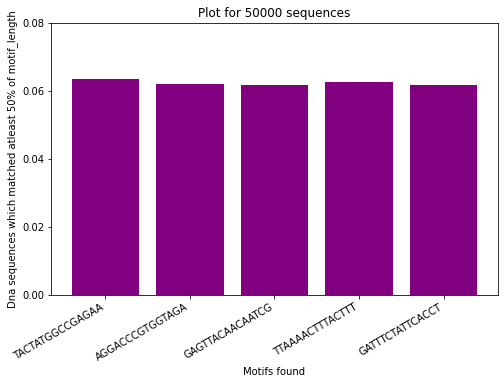

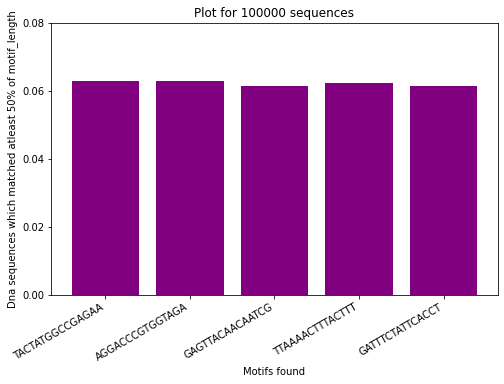

FOR MOTIF LENGTH:  20


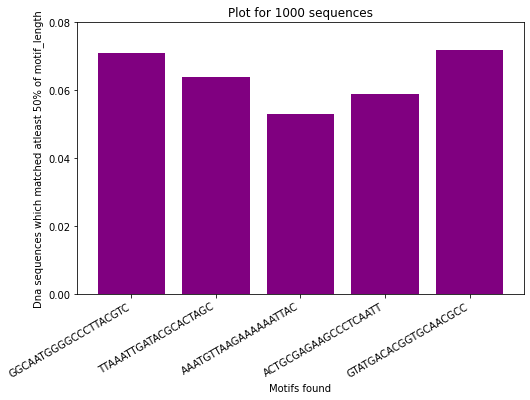

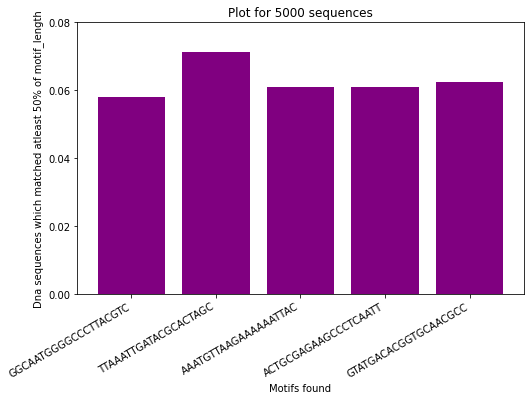

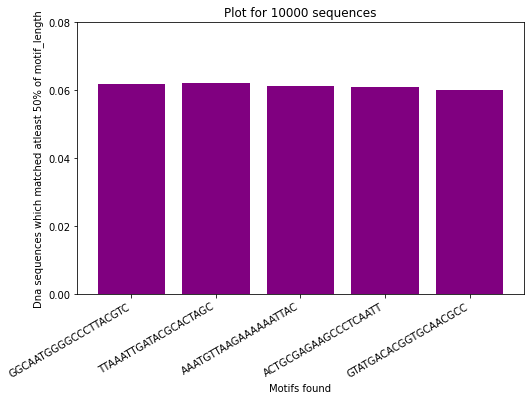

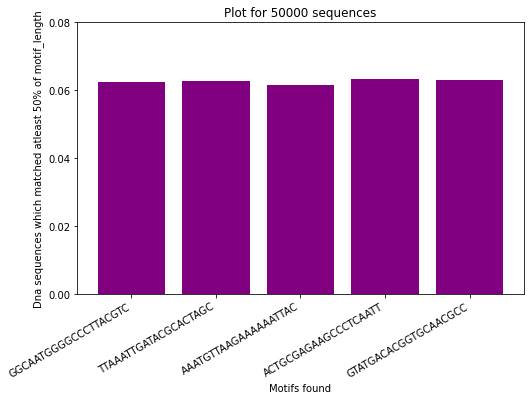

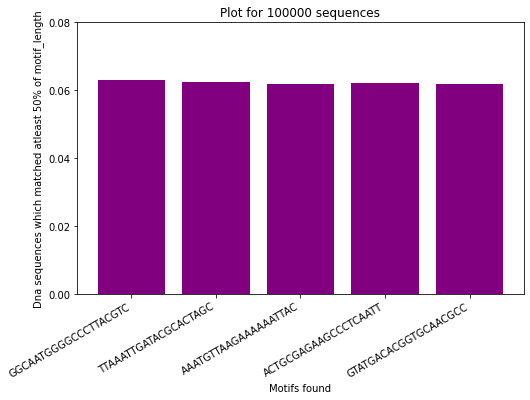

FOR MOTIF LENGTH:  25


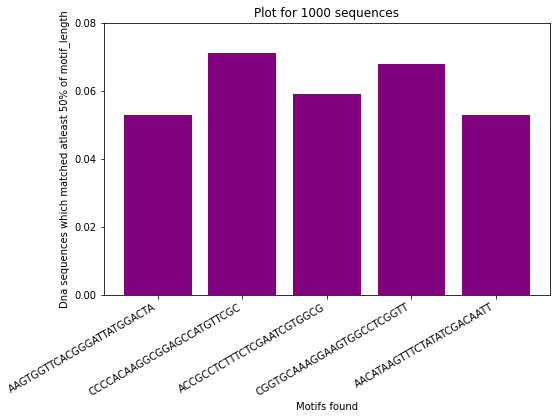

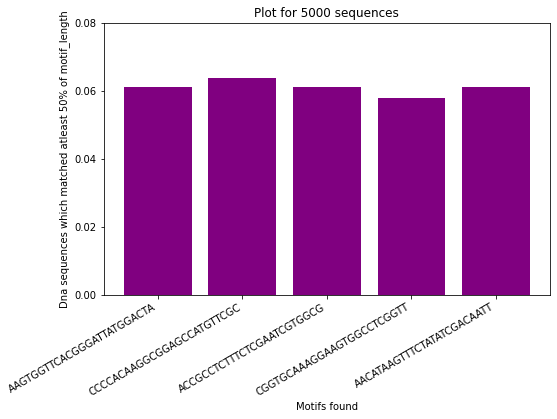

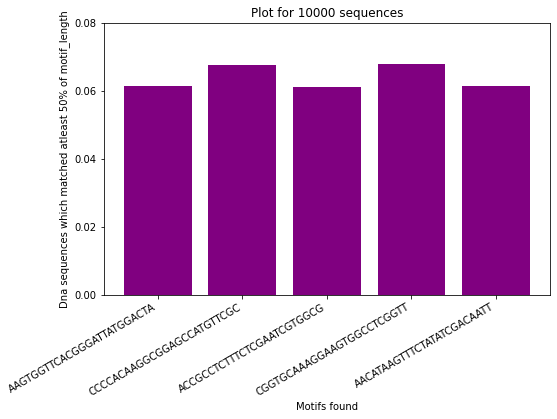

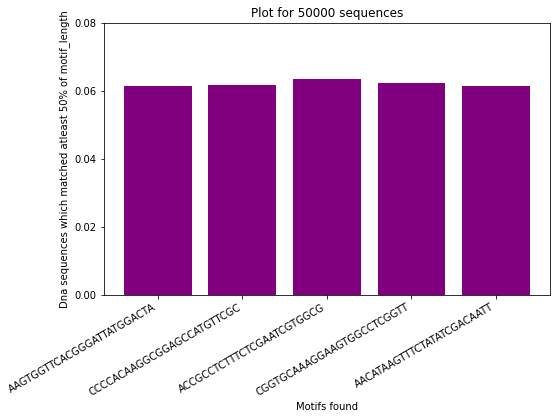

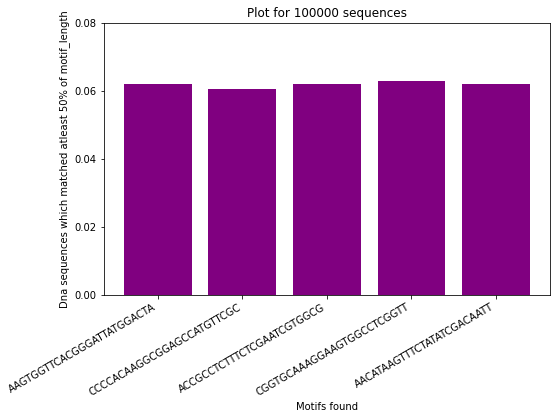

FOR MOTIF LENGTH:  30


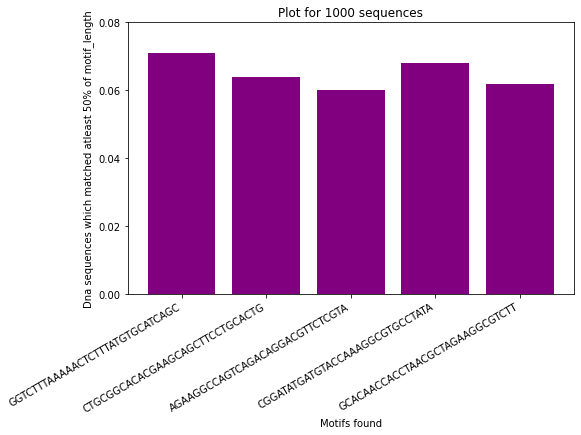

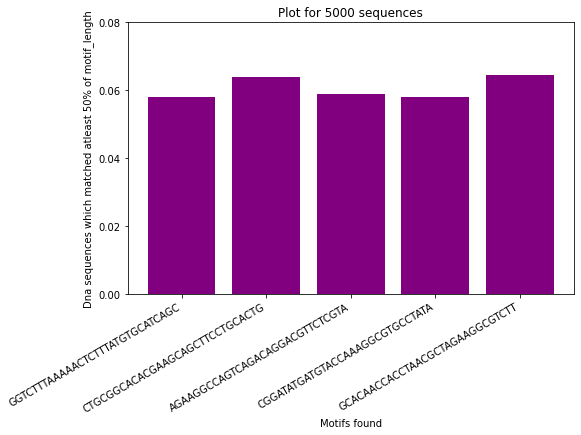

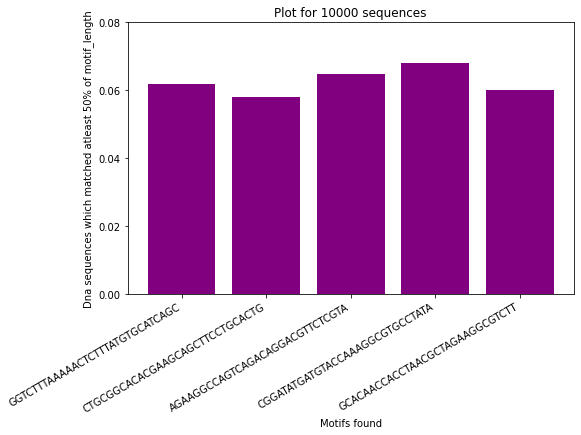

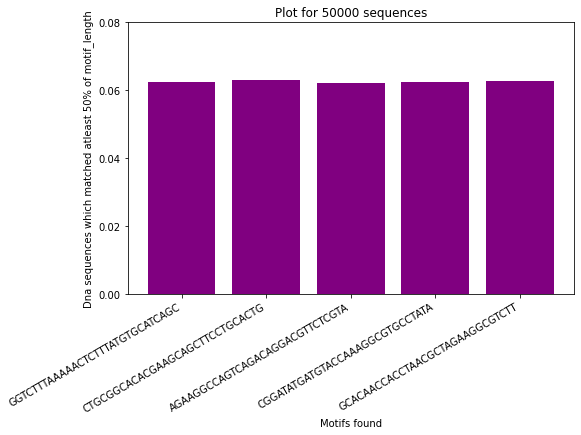

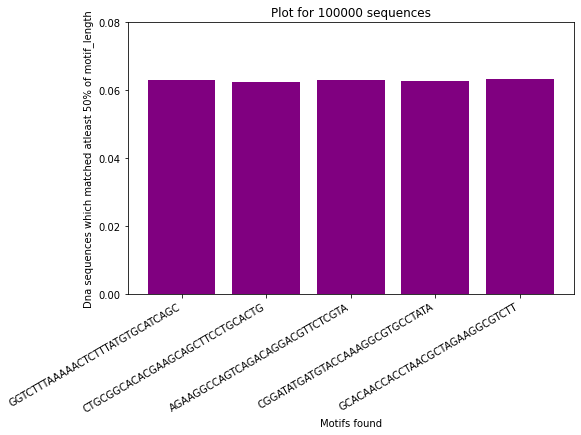

FOR MOTIF LENGTH:  35


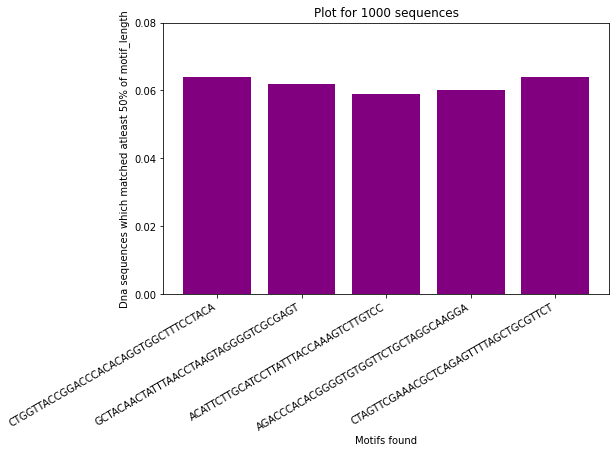

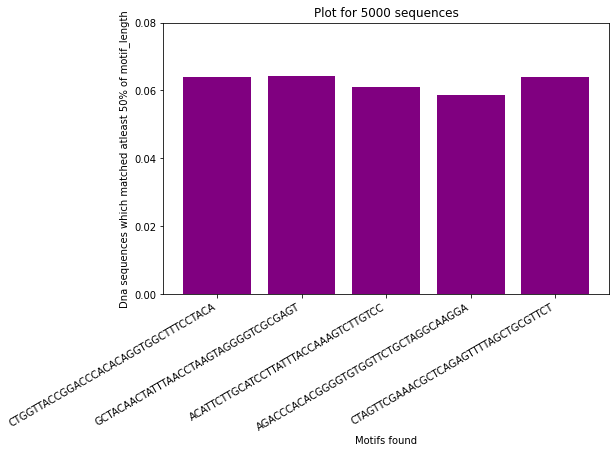

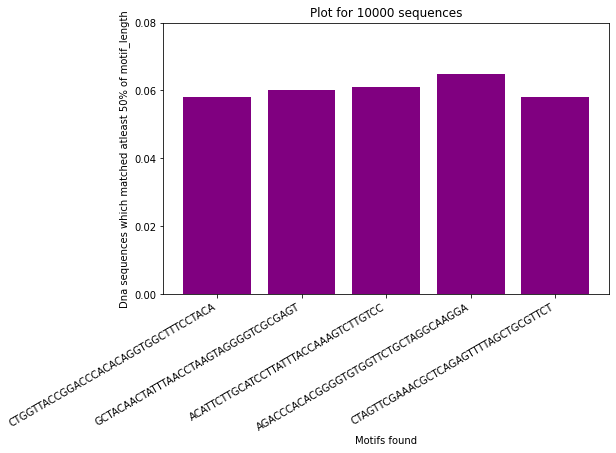

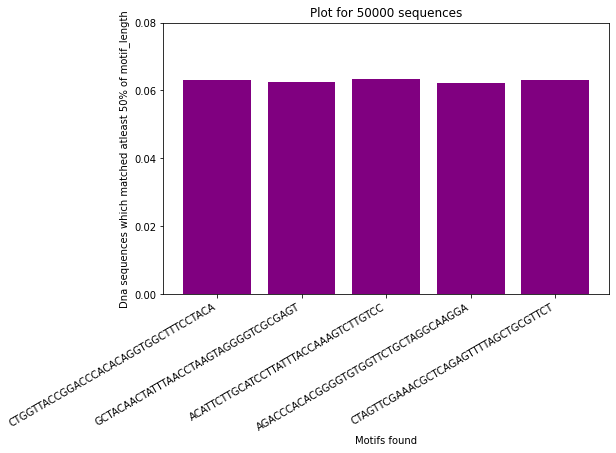

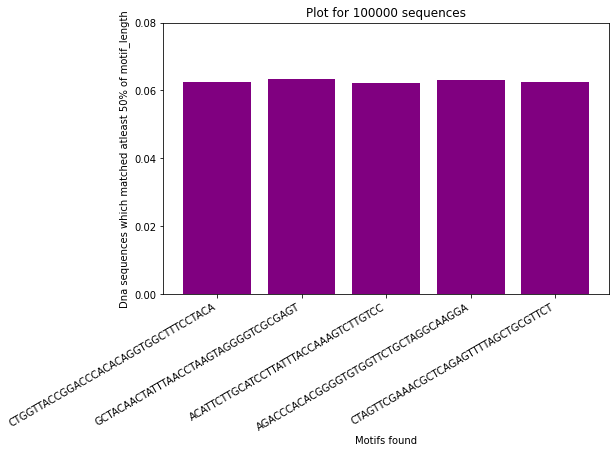

FOR MOTIF LENGTH:  40


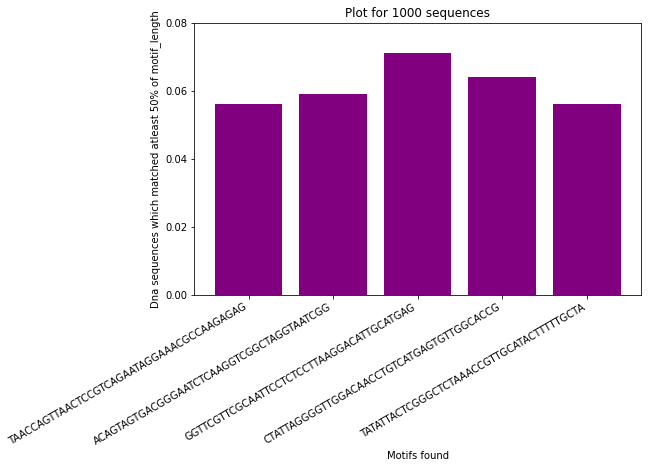

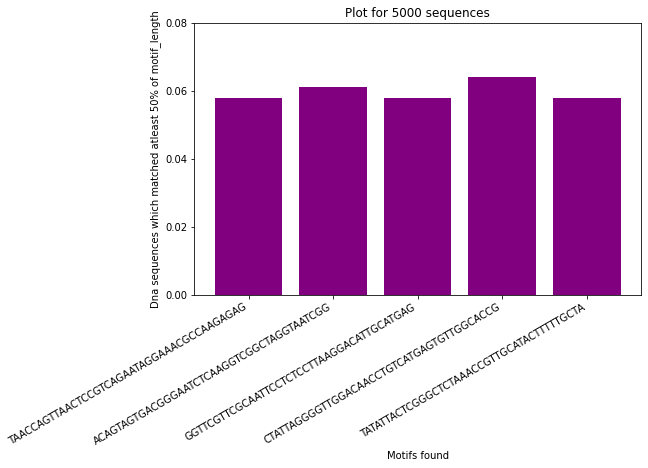

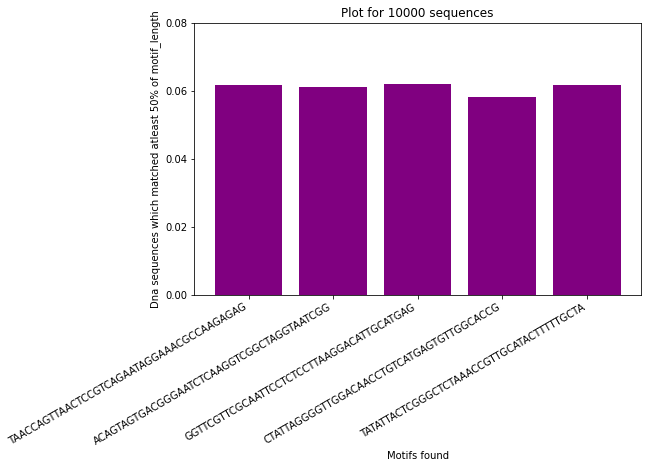

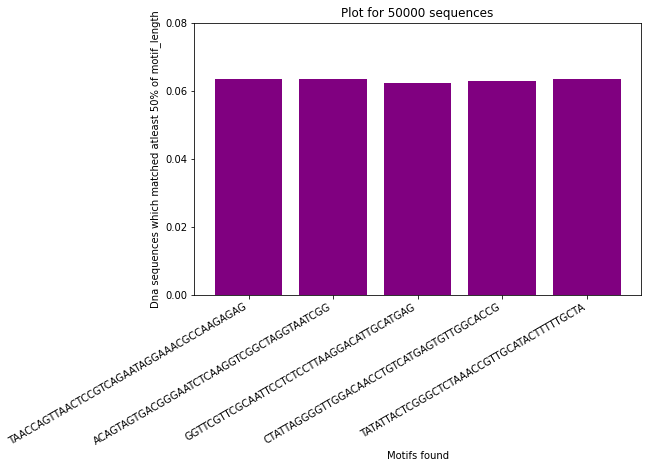

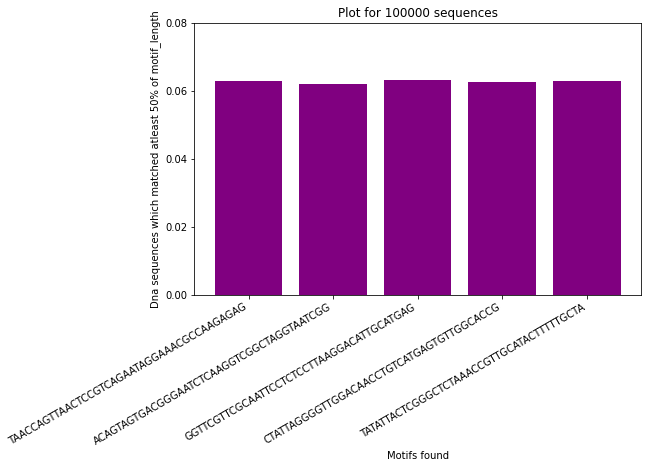

In [19]:
# Plot analysis results per icv
# <motif_length: [{data_size: [normalized_probs], <>}]>
for motif_length in motif_results_per_motif_length:
  print("FOR MOTIF LENGTH: ", motif_length)
  data_and_normalized_vals = motif_results_per_motif_length[motif_length][0]
  motifs_found = motif_results_per_motif_length[motif_length][1]
  for data_size in data_and_normalized_vals:
    data_and_normalized_vals_dict = {data_size : data_and_normalized_vals[data_size]}
    plot_motif_match_observations(motifs_found, data_and_normalized_vals_dict)
print("\n\n")
